In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**hard votiong**

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**soft voting**

In [4]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#'bootstrap=True' means that bagging is used
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.904

**oob score** 

(похоже на использование validation set)

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, oob_score=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

92.5% - неплохо. Проверим на тестовом наборе по фану

In [7]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

# RandomForest

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("accuracy score by training set: {:.4}%".format(acc*100))

y_pred = rnd_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("accuracy score by test set: {:.4}%".format(acc*100))

accuracy score by training set: 95.2%
accuracy score by test set: 91.2%


Теперь почти тоже самое, но используя **BagginClassifier**

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', random_state=42, max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("accuracy score by training set: {:.4}%".format(acc*100))

y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("accuracy score by test set: {:.4}%".format(acc*100))

accuracy score by training set: 93.87%
accuracy score by test set: 92.0%


Тоже, но с использованием **ExtraTreesClassifier**

In [10]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
extra_clf.fit(X_train, y_train)

y_pred = extra_clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("accuracy score by training set: {:.4}%".format(acc*100))

y_pred = extra_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("accuracy score by test set: {:.4}%".format(acc*100))

accuracy score by training set: 92.53%
accuracy score by test set: 91.2%


**Feature impotance / Iris dataset**

In [11]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


**Feature impotance / MNIST dataset**

In [12]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split 

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

x_train, x_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], 
                                                    test_size=0.2, random_state=42)

In [13]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rnd_clf.fit(x_train, y_train)

y_pred = rnd_clf.predict(x_train)
acc = accuracy_score(y_train, y_pred)
print("accuracy score on training set: {:.4}%".format(acc*100))

y_pred = rnd_clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("accuracy score on test set: {:.4}%".format(acc*100))

accuracy score on training set: 100.0%
accuracy score on test set: 96.73%


(-0.5, 27.5, 27.5, -0.5)

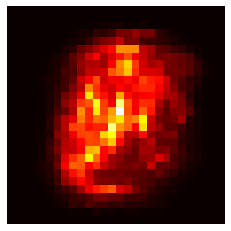

In [14]:
image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
plt.axis("off")